# **Projet - Partie 1 : Classification**
*Kuassi Pierre DOVODJI *

# Sommaire

- [Introduction](#Introduction)
- [I. Lecture, vérification et prétraitements des données](#Lecture-et-vérification-des-données)
    - [Type des variables](#Type-des-variables)
    - [Valeurs manquantes et traitements](#Valeurs-manquantes-et-traitements)
    - [Encodage des variables](#Encodage-des-variables)
- [II. Premières statistiques descriptives](#Statistiques-descriptives)
    - [Nombre de survivants](#Nombre-survivant)
    - [Survivants en fonction du sexe](#Survivant-sexe)
    - [Survivants en fonction de la classe](#Survivant-classe)
    - [Survivants en fonction de l'âge](#Survivant-age)
    - [Matrice de corrélation](#Matrice-correlation)
- [III. Mise en place des différents modèles de classification](#Modèles-classification)
    - [K plus proches voisins](#K-plus-proches-voisins)
    - [Régression logistique](#Régression-logistique)
    - [Analyse discriminate linéaire](#Analyse-discriminate-linéaire)
    - [Random Forest Classifier](#Random-Forest-Classifier)
- [IV. Comparaison des modèles](#Comparaison-modeles)
    - [Comparaison des erreurs d'apprentissage et des erreurs de test](#Comparaison-erreurs)
    - [Comparaison des courbes ROC](#Comparaison-ROC)
- [V. Analyse du meilleur modèle](#Analyse-meilleur-modele)
    - [Matrice de confusion](#Matrice-confusion)
    - [Métriques usuelles - classification_report](#Classification-report)
    - [Importance par permutation](#Importance-permutation)
    - [Graphiques de dépendance partielle](#Dependance-partielle)
    - [Action jointe de deux variables](#Action-jointe)
- [Conclusion](#Conclusion)

---


## I. Introduction



Dans le cadre de l'UE Apprentissage, nous réalisons un projet declassification binaire en utilisant le jeu de données concernant les passagers du Titanic, basé sur des informations suite au naufrage du bateau en 1912. Notre objectif est de prédire si un passager aurait survécu en fonction de l'âge, du sexe, ... . 
Dans un premier temps, nous réalisons une analyse descriptive des données. Ensuite, les données subissent des premiers traitements (imputation de valeurs manquantes, encodage des variables qualitatives) avant d'être séparées en deux parties: un jeu d'entraînement et un jeu de test. Dans un deuxième temps, différents modèles de machine learning seront appliquées (Régression logistique, K plus proches voisins, Random Forest Classifier, LDA et Gradient Boosting Classifier). Les hyperparamètres de ces modèles seront optimisés grâce à la validation croisée. Pour finir, une comparaison des différents modèles nous permettra de sélectionner le modèle le plus performant. Nous approfondirons ce modèle optimal en regardant certaines mesures: la Permutation importance et la Dependence Partial Dependence. 

## I. Lecture, vérification et prétraitements des données

<a id="Lecture-et-vérification-des-données"></a>

In [59]:
#librairies utilisées
import plotly.express as px
import pandas as pd
import seaborn as sns 
from sklearn import datasets
import matplotlib.pyplot as plt 
import warnings
import plotly.io as pio
import numpy as np 
import skimpy
from sklearn.metrics import RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

pio.renderers.default = 'iframe'

warnings.filterwarnings("ignore")
pd.set_option("display.max_rows",None)

#Machine learning 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis 
from sklearn.decomposition import PCA

seed = 4
np.random.seed(seed)

In [29]:
#Lecture du jeu de données
titanic_tot= datasets.fetch_openml(data_id=40945, as_frame=True, parser='auto')
titanic = titanic_tot.frame
print(f"La table de données contient {titanic.shape[0]} observations et {titanic.shape[1]} colonnes.")

La table de données contient 1309 observations et 14 colonnes.


Voici un aperçu rapide du contenu des colonnes:

In [30]:
titanic.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


Voici une description complète de nos variables: 

- **pclass** : classe des passagers (1, 2 ou 3)
- **survived** : si les passagers ont survécu (1, O)
- **name** : nom du passager
- **sex** : sexe du passager (male ou female)
- **sibsp** : nombre de personnes embarquées (les époux·se, les frères et sœurs)
- **parch** : nombre de personnes embarquées (les parents et les enfants)
- **ticket** : numéro du billet
- **fare** : tarif du billet
- **cabin** : numéro de cabine
- **embarked** : porte d'embarquement (C, Q, S)
- **boat** : numéro d'identification du corps
- **home.dest** : destination du passager

### Type des variables  
<a id="Type-des-variables"></a>

Nous vérifions quelles variables sont qualitatives, quantitatives et si nous devons réaliser des modifications.

In [31]:
titanic.dtypes

pclass          int64
survived     category
name           object
sex          category
age           float64
sibsp           int64
parch           int64
ticket         object
fare          float64
cabin          object
embarked     category
boat           object
body          float64
home.dest      object
dtype: object

In [32]:
titanic['pclass'] = titanic['pclass'].astype('category')

variables_quantitatives = titanic.select_dtypes(include=["number"]).columns
variables_catégorielles = titanic.select_dtypes(include=["object", "category"]).columns

print(f"Voici les {len(variables_quantitatives)} variables quantitatives : {variables_quantitatives}")
print(f"Voici les {len(variables_catégorielles)} variables catégorielles: {variables_catégorielles}")


Voici les 5 variables quantitatives : Index(['age', 'sibsp', 'parch', 'fare', 'body'], dtype='object')
Voici les 9 variables catégorielles: Index(['pclass', 'survived', 'name', 'sex', 'ticket', 'cabin', 'embarked',
       'boat', 'home.dest'],
      dtype='object')


### Valeurs manquantes et traitements
<a id="Valeurs-manquantes-et-traitements"></a>

Dans cette sous-section, nous visualisons la répartition des valeurs manquantes et on identifie les variables nécessitant une imputation afin de la réaliser.


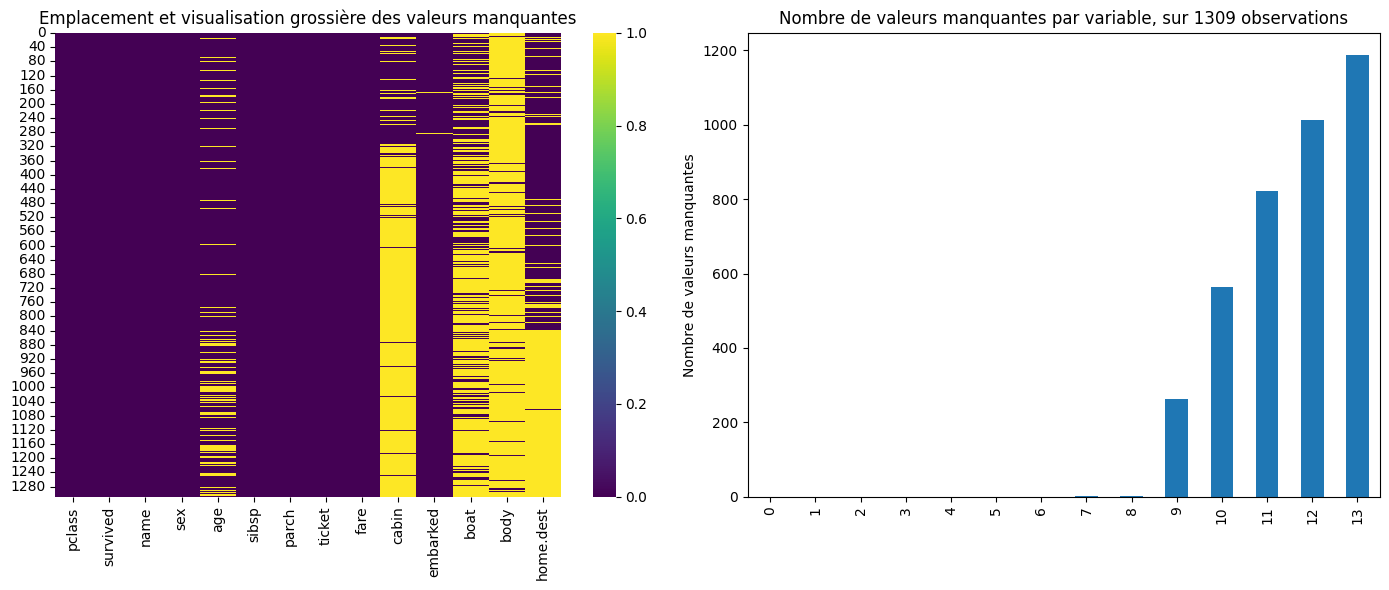

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

#1er graphique: Heatmap des valeurs manquantes
sns.heatmap(titanic.isnull(), cmap="viridis", ax=axes[0])
axes[0].set_title("Emplacement et visualisation grossière des valeurs manquantes")

# 2ème graphique: Bar plot des totaux de valeurs manquantes
totaux_vm = titanic.isnull().sum().sort_values().reset_index()
totaux_vm.plot(kind="bar", ax=axes[1], legend=False)
axes[1].set_title(f"Nombre de valeurs manquantes par variable, sur {titanic.shape[0]} observations")
axes[1].set_ylabel("Nombre de valeurs manquantes")
axes[1].set_xlabel("")

plt.tight_layout()

In [34]:
totaux_vm.columns = ["Variables" , "Nbre_vm"]
totaux_vm['Pourcentages_vm'] = (totaux_vm["Nbre_vm"] / titanic.shape[0]) * 100
totaux_vm

,Variables,Nbre_vm,Pourcentages_vm
0,pclass,0,0.000000
1,survived,0,0.000000
2,name,0,0.000000
3,sex,0,0.000000
4,sibsp,0,0.000000
5,parch,0,0.000000
6,ticket,0,0.000000
7,fare,1,0.076394
8,embarked,2,0.152788
9,age,263,20.091673


Les variables avec beaucoup de valeurs manquantes sont: 

- **age**: 20% de données manquantes.
Représente l'âge des individus. Cette une variable importante quant à la survie car sont souvent priorisés les enfants, personnes vulnérables, etc. Nous imputerons les données manquantes.
  
- **cabin** : 77% de données manquantes.
Représente la localisation dans le bateau d'un individu. Il y a trop de valeurs manquantes et elle ne s'avère sûrement pas primordial afin de comprendre le jeu de données (la variable pclass étant bien renseignée) donc nous supprimerons cette variable.

- **boat** : 63% de données manquantes.
Représente le bateau de sauvetage. On supprime car ce n'est sûrement pas important quant à la survie de l'individu. 

- **body**: 91% de données manquantes.
Représente le numéro d'identification du corps s'il a été retrouvé. Nous considérons cette variable inutile, nous la supprimerons. 

- **home.dest** : 43% de valeurs manquantes.
Représente la destination des individus et nous supprimerons cette variable.

In [35]:
#suppression de name, cabin, boat, body, home.dest, ticket
titanic_survived = titanic.drop(['cabin', 'name', 'body', 'home.dest', 'boat', 'ticket'], axis = 1)


**Méthodes d'imputation**

Les variables à traiter sont les suivantes: age, embarked. 

Plusieurs types d'imputation existent. Voici quelques méthodes: 
- *mean* (remplacer les valeurs manquantes par la moyenne des valeurs non manquantes de la variable)
- *median* (remplacer les valeurs manquantes par la médiane des valeurs non manquantes de la variable)
- *most_frequent* (remplacer les valeurs manquantes par la valeur la plus fréquente de la variable)
- *KNN* avec une valeur k à définir (remplacer les valeurs manquantes en se basant sur les valeurs des k plus proches voisins. Pour chaque valeur manquante, on trouve les k plus proches voisins parmi les valeurs non manquantes pour la variable concernée. La distance utilisée ici est euclidienne. L'algorithme impute la valeur manquante par la valeur moyenne des k voisins les plus proches.)

Ces quatre méthodes sont efficaces lorsque les données manquantes sont dites *MCAR* (Missing Completely At Random), soit que les valeurs manquantes sont indépendantes des autres variables. Les valeurs manquantes ne sont pas liées seulement à la variable en elle-même.

In [36]:
from sklearn.impute import SimpleImputer
def imputer_methode_colonne(df, colonne, methode):
    """
    Imputer les valeurs manquantes dans une colonne selon une méthode choisie. 

    Paramètres :
    - df (pd.DataFrame) : DataFrame 
    - colonne (string) : Nom de la colonne avec valeurs à imputer
    - methode (string) : méthode d'imputation ('mean', 'median', 'most_frequent')

    Retour :
    - pd.DataFrame : DataFrame avec la nouvelle colonne imputée.
    """
    
    imputer = SimpleImputer(strategy=methode)
    
    if df[colonne].dtype in ['int64', 'float64']:  
        df[colonne] = imputer.fit_transform(df[[colonne]])
    else:  
        df[colonne] = imputer.fit_transform(df[[colonne]]).ravel()  
    
    return df

from sklearn.impute import KNNImputer
def imputer_knn_colonne(df, colonne, k=5):
    """
    Imputer les valeurs manquantes d'une colonne - KNNImputer.

    Paramètres :
    - df (pd.DataFrame) : DataFrame 
    - colonne (string) : Nom de la colonne avec valeurs à imputer
    - k (int) : Nombre de voisins pour l'imputation (défaut 5).

    Retour :
    - pd.DataFrame : DataFrame avec la nouvelle colonne imputée.
    """
    knn = KNNImputer(n_neighbors=k, metric='nan_euclidean')
    df[colonne] = knn.fit_transform(df[[colonne]])
    return df

In [37]:
#Imputation âge par KNN
titanic_survived = imputer_knn_colonne(titanic_survived, "age", k=5)

In [38]:
#Imputation embarked et fare par methode most_frequent
titanic_survived = imputer_methode_colonne(titanic_survived, "embarked", "most_frequent")
titanic_survived = imputer_methode_colonne(titanic_survived, "fare", "most_frequent")

In [39]:
vm = titanic_survived.isnull().sum().reset_index()
vm.columns = ['Variables', 'Nombre_vm']
vm['Pourcentages_vm'] = (vm['Nombre_vm'] / titanic_survived.shape[0]) * 100
vm

,Variables,Nombre_vm,Pourcentages_vm
0,pclass,0,0.0
1,survived,0,0.0
2,sex,0,0.0
3,age,0,0.0
4,sibsp,0,0.0
5,parch,0,0.0
6,fare,0,0.0
7,embarked,0,0.0


Les étapes de description de variables aurait pu être réalisé grâce à la librairie skimpy: 

In [40]:
skimpy.skim(titanic)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types               Categories                                        │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓ ┏━━━━━━━━━━━━━━━━━━━━━━━┓                                │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃ ┃ Categorical Variables ┃                                │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩ ┡━━━━━━━━━━━━━━━━━━━━━━━┩                                │
│ │ Number of rows    │ 1309   │ │ string      │ 5     │ │ pclass                │                                │
│ │ Number of columns │ 14     │ │ category    │ 4     │ │ survived              │                                │
│ └───────────────────┴────────┘ │ float64     │ 3     │ │ sex                   │                                │
│                                │ int64       │ 2     │ │ embarked              │                                │
│                                └─────────────┴───────┘ └───────────────────────┘                                │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┓  │
│ ┃ column_name   ┃ NA    ┃ NA %   ┃ mean     ┃ sd      ┃ p0      ┃ p25    ┃ p50    ┃ p75    ┃ p100   ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━┩  │
│ │ age           │   263 │  20.09 │    29.88 │   14.41 │  0.1667 │     21 │     28 │     39 │     80 │ ▂▇▇▃▁  │  │
│ │ sibsp         │     0 │      0 │   0.4989 │   1.042 │       0 │      0 │      0 │      1 │      8 │   ▇    │  │
│ │ parch         │     0 │      0 │    0.385 │  0.8656 │       0 │      0 │      0 │      0 │      9 │   ▇▁   │  │
│ │ fare          │     1 │   0.08 │     33.3 │   51.76 │       0 │  7.896 │  14.45 │  31.27 │  512.3 │   ▇    │  │
│ │ body          │  1188 │  90.76 │    160.8 │    97.7 │       1 │     72 │    155 │    256 │    328 │ ▇▇▇▇▅▇ │  │
│ └───────────────┴───────┴────────┴──────────┴─────────┴─────────┴────────┴────────┴────────┴────────┴────────┘  │
│                                                    category                                                     │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name                      ┃ NA        ┃ NA %           ┃ ordered               ┃ unique             ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩  │
│ │ pclass                           │         0 │              0 │ False                 │                  3 │  │
│ │ survived                         │         0 │              0 │ False                 │                  2 │  │
│ │ sex                              │         0 │              0 │ False                 │                  2 │  │
│ │ embarked                         │         2 │           0.15 │ False                 │                  4 │  │
│ └──────────────────────────────────┴───────────┴────────────────┴───────────────────────┴────────────────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name              ┃ NA         ┃ NA %         ┃ words per row              ┃ total words            ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ name                     │          0 │            0 │                        4.1 │                   5349 │  │
│ │ ticket                   │          0 │            0

### Encodage des variables 
<a id="Encodage-des-variables"></a>
À l’aide de *make_column_transformer* on transforme le jeu de données afin de le préparer pour les modèles de machine learning. Nous utilisons un *OneHotEncoder* avec l'option drop='first' (pour supprimer une catégorie de la variable encodée qui serait redondante et éviter la colinéarité, ici par exemple on encodera pas la variable embarked_C) aux colonnes sex et embarked. Un *StandarScaler* est appliqué aux données numériques afin de les normaliser.

In [41]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
transfo = make_column_transformer(
    (OneHotEncoder(drop="first"), ["sex", "embarked"]), #encodage des variables catégorielles
    (StandardScaler(), titanic_survived.select_dtypes(include=["number"]).columns.tolist()) #normalisation variables numériques
)

In [42]:
donnees_transformees = transfo.fit_transform(titanic_survived)
transfo = make_column_transformer(
    (OneHotEncoder(drop="first"), ["sex", "embarked"]),
    (StandardScaler(), titanic_survived.select_dtypes(include=["number"]).columns.tolist()),
    verbose_feature_names_out=False
)

donnees_transformees = transfo.fit_transform(titanic_survived)
noms_colonnes = transfo.get_feature_names_out()
noms_colonnes

array(['sex_male', 'embarked_Q', 'embarked_S', 'age', 'sibsp', 'parch',
       'fare'], dtype=object)

In [43]:
df_titanic = pd.DataFrame(donnees_transformees, columns=noms_colonnes)
df_titanic['survived'] = titanic_survived['survived'].values

## II. Premières statistiques descriptives 
<a id="Statistiques-descriptives"></a>

In [44]:
titanic_survived.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1309.0,29.881135,12.883199,0.1667,22.0000,29.881135,35.000,80.0000
sibsp,1309.0,0.498854,1.041658,0.0000,0.0000,0.000000,1.000,8.0000
parch,1309.0,0.385027,0.865560,0.0000,0.0000,0.000000,0.000,9.0000
fare,1309.0,33.276193,51.743584,0.0000,7.8958,14.454200,31.275,512.3292


### Nombre de survivants
<a id="Nombre-survivant"></a>

In [45]:
survivants = titanic_survived['survived'].value_counts()
pourcentages = titanic_survived['survived'].value_counts(normalize=True)
print(f"Il y a eu {survivants.iloc[1,]} survivants et {survivants.iloc[0,]} non survivants. Cela représente respectivement {round(pourcentages.iloc[1,],2)}% et {round(pourcentages.iloc[0,],2)}% des passagers.")

Il y a eu 500 survivants et 809 non survivants. Cela représente respectivement 0.38% et 0.62% des passagers.


### Survivants en fonction du sexe
<a id="Survivant-sexe"></a>

In [46]:
fig = px.histogram(
    titanic,
    x='sex',
    color='survived',
    hover_data = titanic_survived.columns,
    title="Nombre de survivants en fonction du sexe",
    barmode='group',
    histnorm='percent'
)

fig.show()

On observe que 68% des femmes ont survécu et seulement 32% parmi les hommes. Ainsi le sexe est sûrement une variable influençant la chance de survie.

### Survivants en fonction de la classe
<a id="Survivant-classe"></a>

In [47]:
fig = px.histogram(
    titanic,
    x='pclass',
    color='survived',
    hover_data = titanic_survived.columns,
    title="Nombre de survivants en fonction de la classe",
    barmode='group',
    histnorm='percent')


fig.show()

Nous observons que la classe est un facteur important. En effet, 40% des personnes en 1ère classe ont survécu et moins dans les deux autres classes: 23.8% pour la 2ème classe et 36.3% pour la deuxième classe. 

### Survivants en fonction de l'âge
<a id="Survivant-age"></a>

In [48]:
bins = [0, 10, 25, 35, 45, 55, 65, float('inf')]
labels = ['<10 ans', '10-25 ans', '25-35 ans', '35-45 ans', '45-55 ans', '55-65 ans', '>65 ans']
titanic['age_range'] = pd.cut(titanic['age'], bins=bins, labels=labels, right=False)
titanic = titanic.sort_values(by='age_range')

fig = px.histogram(
    titanic,
    x='age_range',
    color='survived',
    title="Distribution des survivants par tranches d'âge",
    barmode='group',  
    histnorm='percent',  
    labels={'age_range': 'Tranche d\'âge', 'survived': 'Survécu'}
)


fig.update_layout(
    xaxis_title="Tranche d'âge",
    yaxis_title="Pourcentage",
    legend_title="Survécu",
    bargap=0.2 
)

fig.show()


Grâce au graphique, nous constatons bien les disparitées concernant l'âge et la survie.

### Matrice de corrélation
<a id="Matrice-correlation"></a>

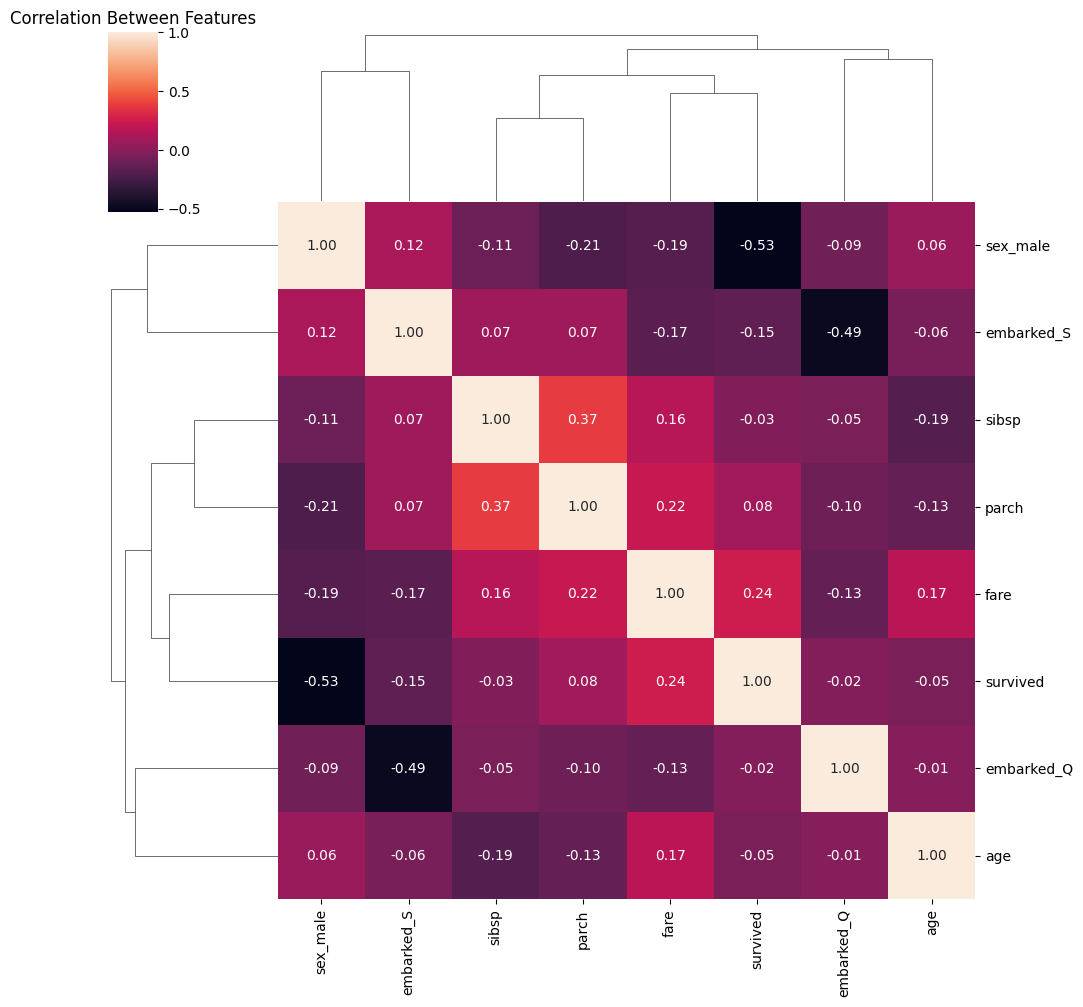

In [50]:
#Correlation
corr_matrix = df_titanic.corr()
sns.clustermap(corr_matrix, annot = True, fmt = ".2f", figsize=(10,10))
plt.title("Correlation Between Features")
plt.show()

La matrice de corrélation indique différentes valeurs: 

- -0.53 pour la corrélation entre **survived et sex_male**. Il y a une corrélation négative, ce qui est cohérent avec le fait que les femmes étaient sûrement prioritaires dans le sauvetage.

- 0.24 pour la corrélation entre **survived et fare** (tarif du billet). Il y a une corrélation positive. Comme nous l'avons vu, les personnes en première classe ont un pourcentage de survivants plus élevé donc cette valeur est aussi cohérente.

- il est difficile d'exploiter les variables **sibsp** et **parch**, mais nous pourrions penser que les familles nombreuses (avec enfants) seraient prioritaires. 

## III. Mise en place des différents modèles de classification
<a id="Modèles-classification"></a>

In [54]:
# Train test split
x_train, x_test, y_train, y_test = train_test_split(df_titanic.drop("survived", axis='columns'), df_titanic["survived"], test_size = 0.30, random_state = seed)

y_train = pd.to_numeric(y_train, errors='coerce')
y_test = pd.to_numeric(y_test, errors='coerce')

## K plus proches voisins
<a id="K-plus-proches-voisins"></a>

Nous mettons en placee l'algorithme des k plus proches voisins (se basant sur une distance) tout en restant vigilant à l'hyperparamètre k. UN k trop faible pouvant favoriser le sur-apprentissage et un k trop élevé, un sous-apprentissage. 
k sera choisi grâce à la validation croisée (5 blocs). 

In [60]:
model_empty = KNeighborsClassifier()

param_grid = {'n_neighbors': range(1, 101)}

grid_search = GridSearchCV(model_empty, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
mod = grid_search.fit(x_train, y_train)
results = pd.DataFrame(grid_search.cv_results_)
model1 = mod.best_estimator_
R2_test = model1.score(x_test, y_test)
y_pred = model1.predict(x_test)
accuracy_knn = accuracy_score(y_test, y_pred)
f1_class_0 = f1_score(y_test, y_pred, pos_label=0)  
f1_class_1 = f1_score(y_test, y_pred, pos_label=1)  


print(f"L'hyperparamètre optimal est {mod.best_params_} avec une erreur moyenne en validation croisée R2_cv = {-1 *mod.best_score_:.3f}")
print(f"La performance sur l'échantillon test est R2_test = {R2_test:.3f}")
print(f"L'accuracy du modèle KNN sur les données de test est : {accuracy_knn:.3f}")
print(f"F1-score pour la classe 0 : {f1_class_0:.3f}")
print(f"F1-score pour la classe 1 : {f1_class_1:.3f}")

L'hyperparamètre optimal est {'n_neighbors': 22} avec une erreur moyenne en validation croisée R2_cv = 0.207
La performance sur l'échantillon test est R2_test = 0.776
L'accuracy du modèle KNN sur les données de test est : 0.776
F1-score pour la classe 0 : 0.822
F1-score pour la classe 1 : 0.699


Nous pouvons retrouver la valeur optimale k=22 grâce au graphe suivant. En effet, l'erreur minimale est bien à 22. Pour les valeurs inférieures à 22, l'erreur est plus élevée. Il y a un sur-apprentissage pour les valeurs de k petites (modèle trop complexe) et un sous-apprentissage pour des valeurs de k grandes (l'erreur augmente).

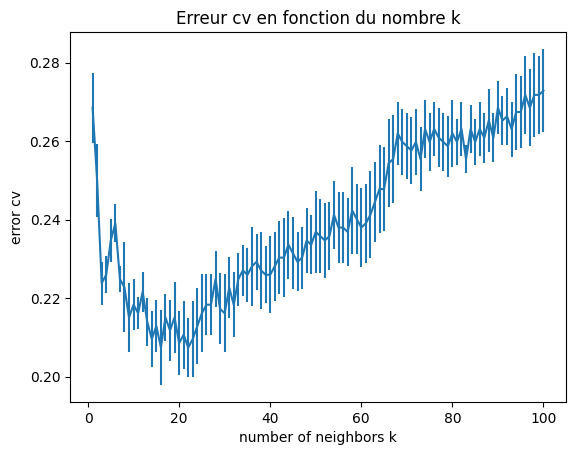

In [26]:
err_cv = -results['mean_test_score']
plt.errorbar(results['param_n_neighbors'],-results['mean_test_score'],results['std_test_score']/np.sqrt(5))
plt.xlabel('number of neighbors k')
plt.ylabel('error cv')
plt.title("Erreur cv en fonction du nombre k")
plt.show()

En plus de cela, nous utilisons la courbe ROC pour évaluer la performance du modèle:

erreur d'apprentissage = 0.206, erreur test = 0.224


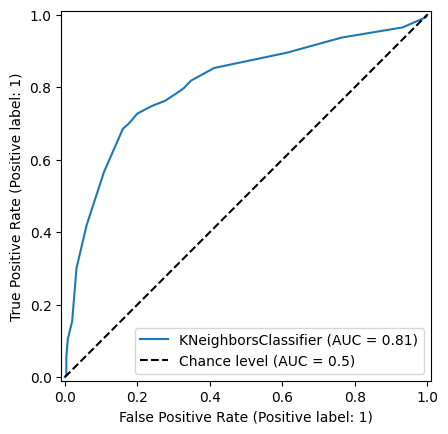

In [27]:
model1 = grid_search.best_estimator_
# calcul de l'erreur 
err_train = 1-model1.score(x_train,y_train)
err_test = 1-model1.score(x_test,y_test)
print(f"erreur d\'apprentissage = {err_train:.3f}, erreur test = {err_test:.3f}")
RocCurveDisplay.from_estimator(model1,x_test,y_test, 
                               plot_chance_level=True)
plt.show()

La valeur *AUC* est de 0.82, donc le modèle distingue plutôt bien les deux classes. 
De plus, les deux valeurs de test ne semblent pas indiquer de problème quant au modèle obtenu.

## Régression logistique
<a id="Régression-logistique"></a>

erreur d'apprentissage = 0.216, erreur test = 0.242 

              precision    recall  f1-score   support

           0       0.82      0.79      0.81       250
           1       0.66      0.71      0.68       143

    accuracy                           0.76       393
   macro avg       0.74      0.75      0.74       393
weighted avg       0.76      0.76      0.76       393



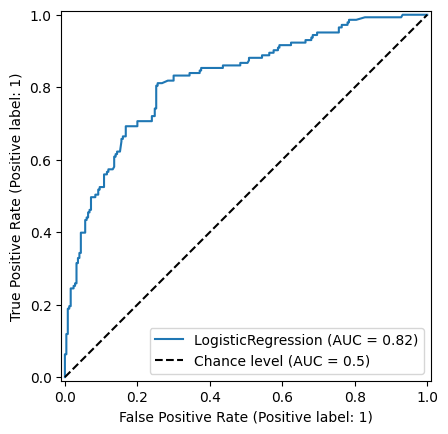

In [62]:
from sklearn.metrics import classification_report

model2 = LogisticRegression(solver='newton-cg')    
model2.fit(x_train,y_train)
err_train2 = 1-model2.score(x_train,y_train)
err_test2 = 1-model2.score(x_test,y_test)
print(f"erreur d\'apprentissage = {err_train2:.3f}, erreur test = {err_test2:.3f} \n")

y_pred = model2.predict(x_test)
print(classification_report(y_test,y_pred))

RocCurveDisplay.from_estimator(model2,x_test,y_test, 
                               plot_chance_level=True)
plt.show()

L'erreur d'apprentissage obtenu est 0.216, donc le modèle est plutôt bien ajusté aux données d'entraînement. L'erreur de test est 0.242 donc le modèle a réussi à prédire les valeurs de l'échantillon test. 

L'accuracy est de 76%. Cette métrique indique la proportion des prédictions correctes (positives et négatives). C'est un bon score mais il vaut mieux regarder le F1-score car cette métrique peut ne pas être un bon indicateur si les classes sont déséquilibrées. En effet, il considère aussi les vrais positifs et les faux négatifs.  
Ainsi le F1-score pour la classe 0 est 0.81 et pour la classe 1, 0.68, ce qui est un résultat plus faible.

Pour la classe 0 (majoritaire - 250), la précision est de 82%, donc 82% es prédictions étaient correctes.
$$Précision = \frac{Vrais~positifs (TP)}{Vrais~positifs (TP) + Faux~positifs (FP)}$$

Le rappel est de 79%. 
$$ Rappel = \frac{Vrais~positifs (TP)}{Vrais~positifs (TP) + Faux~négatifs (FN)}$$

Pour la classe 1 (minoritaire - 143) la précision de 66% indique de moins bons résultats, car 34% des prédictions pour cette dernière était fausses et le rappl est de 71%.

## Analyse discriminate linéaire
<a id="Analyse-discriminate-linéaire"></a>

Nous allons chercher à séparer les classes. Pour cela nous optimisons des paramètres du modèle: solver et shrinkage. 

Le solver permet de choisir la méthode utilisée et est important quant à l'efficacité et la vitesse de convergence, nous testons SVD (Singular Value Decomposition), lsqr (Leat Squares Quadratic Regularization) et eigen (Eigen decomposition) basée sur la décomposition en valeurs propres. 

Le shrinkage permet plutôt de régulariser le modèle. Nous essayons, None (aucune régularisation), auto (valeur choisie par le modèle), puis 0.1, 0.5, 1. Les valeurs élevées permettront une grande réduction de variance et un modèle simple.



Meilleurs paramètres : {'shrinkage': None, 'solver': 'svd'}
Meilleure performance (validation croisée) : 0.789
Erreur d'apprentissage : 0.209, Erreur de test : 0.234
L'accuracy du modèle LDA sur les données de test est : 0.766
F1-score pour la classe 0 : 0.813
F1-score pour la classe 1 : 0.687


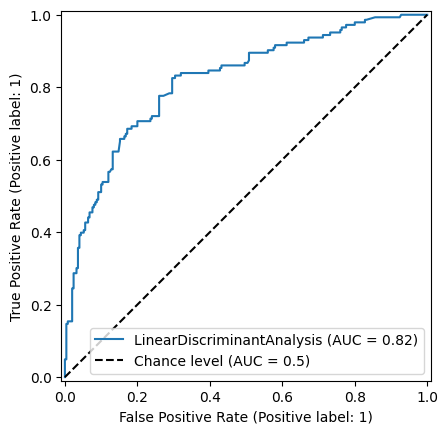

In [61]:
from sklearn.model_selection import GridSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

model3 = LinearDiscriminantAnalysis()

param_grid = {
    'solver': ['svd', 'lsqr', 'eigen'],       
    'shrinkage': [None, 'auto', 0.1, 0.5, 1]  
}

grid_search = GridSearchCV(model3, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1)
grid_search.fit(x_train, y_train)

model3 = grid_search.best_estimator_
print(f"Meilleurs paramètres : {grid_search.best_params_}")
print(f"Meilleure performance (validation croisée) : {grid_search.best_score_:.3f}")

err_train = 1 - model3.score(x_train, y_train)
err_test = 1 - model3.score(x_test, y_test)
print(f"Erreur d'apprentissage : {err_train:.3f}, Erreur de test : {err_test:.3f}")

y_pred = model3.predict(x_test)
accuracy_knn = accuracy_score(y_test, y_pred)
f1_class_0 = f1_score(y_test, y_pred, pos_label=0)  
f1_class_1 = f1_score(y_test, y_pred, pos_label=1)  



print(f"L'accuracy du modèle LDA sur les données de test est : {accuracy_knn:.3f}")
print(f"F1-score pour la classe 0 : {f1_class_0:.3f}")
print(f"F1-score pour la classe 1 : {f1_class_1:.3f}")

from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_estimator(model3, x_test, y_test, plot_chance_level=True)
plt.show()


Comme dans les modèles précédents, les erreurs d'apprentissage et de test ne sont pas alarmantes. 

Quant au graphique, l'AUC vaut 0.82 donc le modèle est valide.

## Random Forest Classifier
<a id="Random-Forest-Classifier"></a>

Nous réalisons un dernier modèle, la forêt aléatoire en optimisant les paramètres suivants par validation croisée: 

- **n_estimators** : le nombre d'arbres
- **max_depth** : la profondeur de l'arbre (pour faire attention au sur-apprentissage)
- **min_samples_split** : nombre minimum d'échantillons pour séparer un noeud
- **min_samples_leaf** : nombre minimal d'échantillon pour une feuille

  

Fitting 5 folds for each of 135 candidates, totalling 675 fits
Meilleurs paramètres : {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Erreur d'apprentissage : 0.179
Erreur de test : 0.219


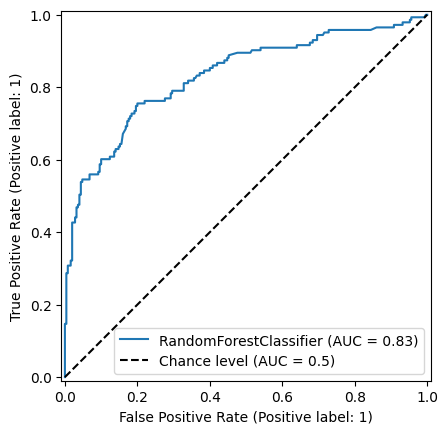

In [30]:
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'n_estimators': [50, 100, 200],        
    'max_depth': [3, 5, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

model4 = RandomForestClassifier(max_features=int(np.sqrt(8)), random_state=4)

grid_search = GridSearchCV(estimator=model4, param_grid=param_grid, 
                           scoring='neg_mean_squared_error', cv=5, n_jobs=-1, verbose=1)
grid_search.fit(x_train, y_train)

model4 = grid_search.best_estimator_
err_train4 = 1 - model4.score(x_train, y_train)
err_test4 = 1 - model4.score(x_test, y_test)
print(f"Meilleurs paramètres : {grid_search.best_params_}")
print(f"Erreur d'apprentissage : {err_train4:.3f}")
print(f"Erreur de test : {err_test4:.3f}")

RocCurveDisplay.from_estimator(model4, x_test, y_test, plot_chance_level=True)
plt.show()


L'erreur d'apprentissage indiquée est très faible (0.18) donc le modèle s'ajuste a priori très bien aux données d'entraînement, sans sur-apprentissage. L'erreur de test est 0.226 donc le  modèle arrive à appréhender de nouvelles données.

La courbe ROC est correcte avec un AUC de 0.84 donc le modèle semble pouvoir distinguer les classes correctement. 

## IV. Comparaison des modèles
<a id="Comparaison-modeles"></a>

### Comparaison des erreurs d'apprentissage et des erreurs de test
<a id="Comparaison-erreurs"></a>

Commençons la comparaison des modèles par la comparaison des erreurs d'apprentissage et de test.

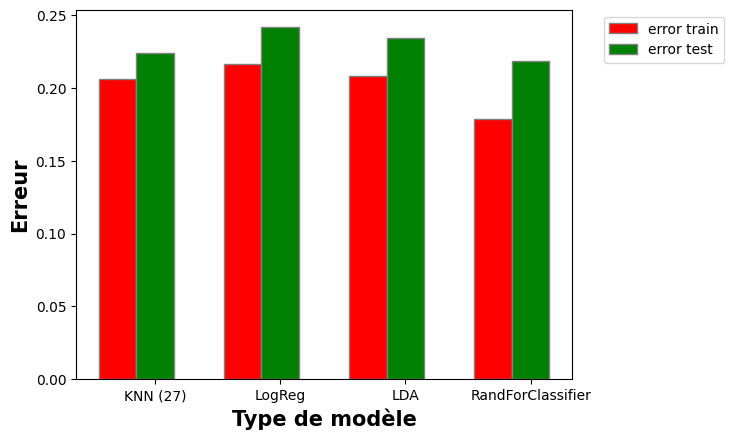

In [31]:
all_models = [model1,model2,model3, model4] 
all_err_train = [1-model.score(x_train,y_train) for l, model in enumerate(all_models)]
all_err_test = [1-model.score(x_test,y_test) for l, model in enumerate(all_models)]

model_names = ["KNN (27)","LogReg", "LDA", "RandForClassifier"] 

fig = plt.subplots()
br1 = np.arange(len(all_err_train)) 
br2 = [x + 0.3 for x in br1] 

plt.bar(br1, all_err_train, color ='r', width = 0.3, 
        edgecolor ='grey', label ='error train') 
plt.bar(br2, all_err_test, color ='g', width = 0.3, 
        edgecolor ='grey', label ='error test') 

plt.xlabel('Type de modèle', fontweight ='bold', fontsize = 15) 
plt.ylabel('Erreur', fontweight ='bold', fontsize = 15) 
plt.xticks([r + 0.3 for r in range(len(all_err_train))], 
        model_names)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

RandomForest et KNN sont les meilleurs modèles avec une erreur de test la plus faible d'environ 22% alors que les deux autres ont des valeurs d'erreur de test un peu plus élevées.

### Comparaison des courbes ROC
<a id="Comparaison-ROC"></a>

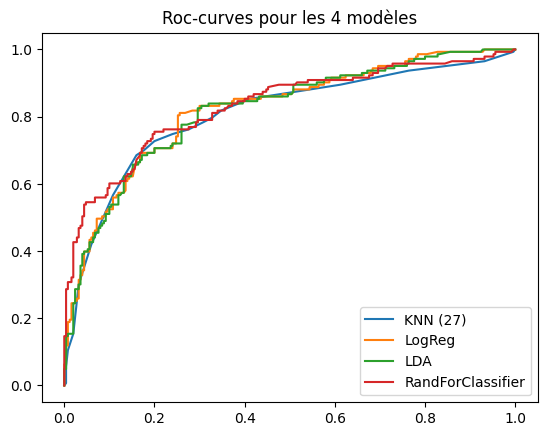

In [32]:
from sklearn.metrics import roc_curve

for l, model in enumerate(all_models):
    y_score = model.predict_proba(x_test)[:,1]
    fp, tp, thresholds = roc_curve(y_test, y_score, pos_label=1)
    plt.plot(fp, tp, label = model_names[l])
    plt.legend(loc="lower right", fontsize=10)

plt.title("Roc-curves pour les 4 modèles")
plt.show()

Nous retiendrons le modèle RandomForest car la ligne rouge semble au-dessus des autres courbes à plusieurs endroits.

# Analyse du meilleur modèle
<a id="Analyse-meilleure-modele"></a>

## Matrice de confusion
<a id="Matrice-confusion"></a>

La matrice de confusion est : 



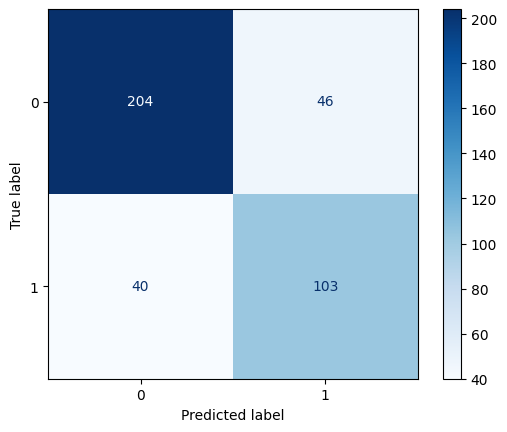

In [33]:
from sklearn.metrics import ConfusionMatrixDisplay
y_pred = model4.predict(x_test)
cm = confusion_matrix(y_test, y_pred, labels=model4.classes_)
print(f"La matrice de confusion est : \n")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model4.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Le tableau fournit les informations suivantes: 
- 204 vrais négatifs (TN) 
204 passagers n'ont pas survécu (0) et ont été identifiés tel quel. 

- 46 Faux positifs (FP) 
46 passagers ont été classés comme ayant survécu(1) alors qu'ils n'avaient pas survécu(0).

- 40 Faux négatifs (FN)
40 passagers qui ont survécu(1) ont été classés comme ayant non survécu(0).

- 103 Vrais positifs (TP)
103 individus ont survécu(1) et ont été identifiés tel quel. 

## Métriques usuelles - classification_report 
<a id="Classification-report"></a>


In [34]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.84      0.82      0.83       250
           1       0.69      0.72      0.71       143

    accuracy                           0.78       393
   macro avg       0.76      0.77      0.77       393
weighted avg       0.78      0.78      0.78       393



On retrouve la précision valant 69%, le rappel 72%, le F1-score 70.5% et l'accuracy 78.4%. Comme nous avions pu constater le modèle prédit très bien les passagers appartenant à la classe 0 mais fait quelques erreurs pour la classe 1. 


## Importance par permutation
<a id="Importance-permutation"></a>


Nous regardons les *importances par permutation* pour constater l'effet de toutes les variables sur la performance du modèle. 

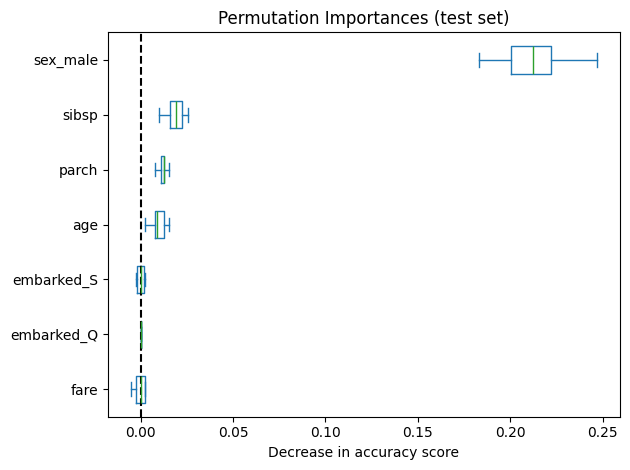

In [35]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    model4, x_test, y_test, n_repeats=10, random_state=42, n_jobs=-1
)
sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=df_titanic.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

Le graphe nous permet de constater que **sex_male** est une variable importante pour la prédiction. Les variables **age**, **sibsp**, **parch** sont aussi importantes.

Nous pouvons en conclure que le sexe (homme ou femme), l'âge (jeunes enfants ou non), le nombre parents proches jouent un rôle dans la possibilité de survie. 

Les autres variables sont considérées comme peu importante. 

## Graphiques de dépendance partielle
<a id="Dependance-partielle"></a>

Pour finir, nous regardons les graphes de dépendance partielle afin de comprendre comment les variables les plus importantes influent la prédiction (relations, linéaires, non linéaires, ...) en isolant leur effet.

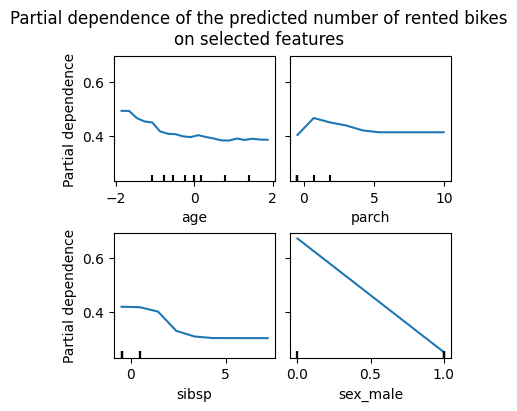

In [36]:
from sklearn.inspection import PartialDependenceDisplay


common_params = {
    "subsample": 50,
    "n_jobs": -1,
    "grid_resolution": 20,
    "random_state": 0,
}
features_info = {
    "features": df_titanic.columns[sorted_importances_idx[3:8]],  
    "kind": "average",
}

fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(4, 4), constrained_layout=True)
display = PartialDependenceDisplay.from_estimator(
    model4,
    pd.DataFrame(x_test, columns=df_titanic.drop(columns=['survived']).columns),
    **features_info,
    ax=ax,
    **common_params,
)
fig = display.figure_.suptitle(
    "Partial dependence",
    fontsize=12,
)


Quant à l'âge, on voit que la possibilité de survie diminue quand l'âge augmente mais cela n'a l'air d'avoir qu'un faible impact. 

Pour le sexe, on voit clairement que les hommes ont une chance de survie plus faible. 

Les courbes pour parch et sibsp ont des allures variables selon le nombre d'individus composant le foyer. Pour sibsp, nous constatons qu'à partir de 2 frères-soeurs-conjoints, la probabilité de survie chûte mais avant cela elle est forte. Quant à la variable parch, nous constatons aussi qu'il valait mieux être seul ou peu accompagné (nombre de parents/enfants), mais la décroissance de la courbe est moins importante que pour sibsp. Les mères (ou parents) étaient probablement moins séparées de leurs enfants.

### Action jointe de deux variables
<a id="Action-jointe"></a>

Nous allons maintenant regarder l'action combiné des variables suivantes: âge et sex_mal puis sibsp et parch. Au préalable nous avons vérifié la corrélation entre ces couples et nous obtenons respectivement 0.06 et 0.37. Ainsi, il y a une légére corrélation positive entre parch et sibsp donc nous pourrions réaliser une interprétation trompeuse.

Pour l'interprétation des heatmap, nous allons être à la fois vigilnt à la direction des lignes mais aussi aux couleurs. 

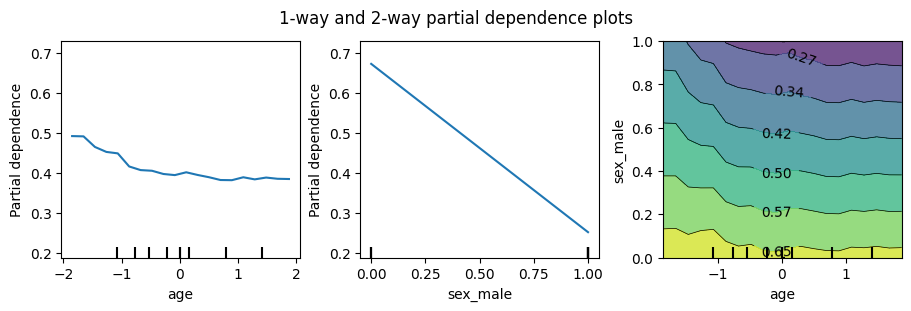

In [37]:
features_info = {
    "features":  ["age","sex_male",("age", "sex_male")],
    "kind": "average",
}
fig, ax = plt.subplots(ncols=3, figsize=(9, 3), constrained_layout=True)
display = PartialDependenceDisplay.from_estimator(
    model4,
    pd.DataFrame(x_test, columns=df_titanic.drop(columns=['survived']).columns),
    **features_info,
    ax=ax,
    **common_params,
)
fig = display.figure_.suptitle(
    "1-way and 2-way partial dependence plots", fontsize=12
)

En couleur, nous observons la probabilité de survie. En jaune il s'agit de la zone où on a la probabilité la plus forte de survie et en violet la plus faible. 

Nous constatons donc que les plus jeunes et jeune femmes ont une probabilité de survie la plus élevée  et que les hommes âgés ont moins de chance de survie. Cela est en cohérence avec ce que nous avons interprété précédemment. 


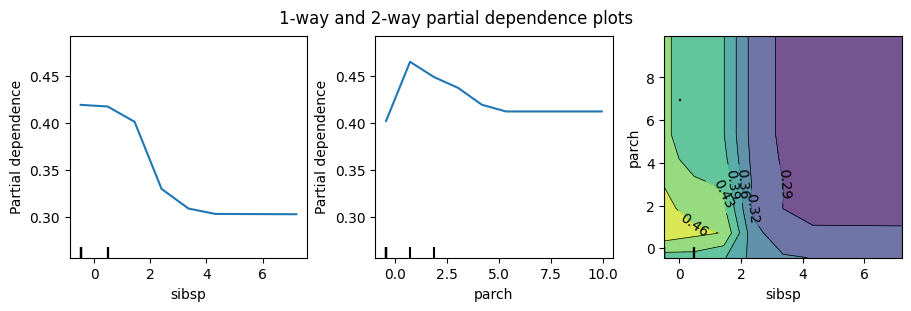

In [38]:
features_info = {
    "features":  ["sibsp","parch",("sibsp", "parch")],
    "kind": "average",
}
fig, ax = plt.subplots(ncols=3, figsize=(9, 3), constrained_layout=True)
display = PartialDependenceDisplay.from_estimator(
    model4,
    pd.DataFrame(x_test, columns=df_titanic.drop(columns=['survived']).columns),
    **features_info,
    ax=ax,
    **common_params,
)
fig = display.figure_.suptitle(
    "1-way and 2-way partial dependence plots", fontsize=12
)

L'action jointe des variables sibsp et parch est un peu plus délicate à interpréter. Nous observons toujours en jaune la zone où la probabilité de survie est la plus élevée et en violet la plus faible. 
Nous retrouvons le fait que les personnes voyageant seules avaient une probabilité plus élevée de survie et les groupes les plus nombreux avaient moins de chance.

# Conclusion

A travers ce document, nous avons parcouru différents modèes de classification (KNN, régression logistique, analyse discriminante linéaire, forêt alétoire) sur les données concernant la survie des passagers du Titanic. Le modèle le plus performant était le modèle de Forêt aléatoire, même si les autres modaines ont aussi montré une bonne capacité de généralisation. 

La matrice de confusion nous a permis de voir que le modèle classifiait bien la prédiction des passagers non survivants mais était moins performant concernant les passagers ayant survécus. La précision, le rappel et le F1-score nous ont permis d'appuyer cette idée. 

Les variables les plus importantes de notre modèle sont le sexe, l'âge et la dimension du foyer. Nous pouvons conclure que les jeunes, les jeunes femmes, ont plus de chance de survie, au contraire des hommes. A cela s'ajoute le fait que les personnes voyageant seules avaient plus de chances de survie. 